# Gaussian Interactive Example

### Setup

In [1]:
import os
# Set id of available GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

import time

import jax
import jax.numpy as jnp

import haiku as hk
import numpy as np
import optax

import matplotlib.pyplot as plt
import seaborn as sns

import tqdm

from functools import partial

from jaxtyping import PRNGKeyArray as Key, Array
import typing as tp
from check_shapes import check_shapes

from pdds.sde import SDE, guidance_loss
from pdds.smc_problem import SMCProblem
from pdds.potentials import NNApproximatedPotential
from pdds.utils.shaping import broadcast
from pdds.utils.jax import (
    _get_key_iter,
    x_gradient_stateful_parametrised,
)
from pdds.utils.lr_schedules import loop_schedule
from pdds.ml_tools.state import TrainingState
from pdds.smc_loops import fast_outer_loop_smc
from pdds.distributions import NormalDistributionWrapper
from pdds.sde import LinearScheduler, SDE
from pdds.potentials import RatioPotential, NaivelyApproximatedPotential, NNApproximatedPotential
from pdds.nn_models.mlp import PISGRADNet
from pdds.resampling import resampler


2024-02-08 14:33:55.726089: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Explore the naive potential approximation
First we check out the performance of PDDS algorithm with the naive potential approximation.

Naive log Z estimate:  -12.374804573059082


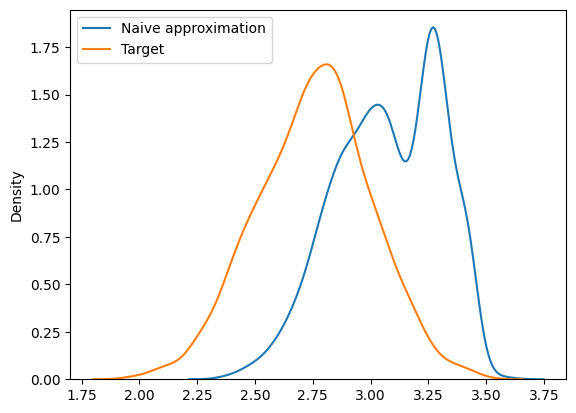

In [2]:
# global variables
dim=1
sigma=1.0
t_0=0.0
t_f=1.0
num_steps=8
num_particles=2000

# INSTANTIATE OBJECTS

# Instantiate key iterator
key = jax.random.PRNGKey(seed=0)
key_iter = _get_key_iter(key)

# Instantiate target
target_distribution = NormalDistributionWrapper(mean=2.75, scale=0.25, dim=dim, is_target=True)

# Instantiate SDE
scheduler = LinearScheduler(t_0=t_0, t_f=t_f, beta_0=0.001, beta_f=12.0)
sde = SDE(scheduler, sigma=sigma, dim=dim)

# Instantiate potential classes
log_g0 = RatioPotential(sigma=sigma, target=target_distribution)
uncorrected_approx_potential = NaivelyApproximatedPotential(base_potential=log_g0, dim=dim, nn_potential_approximator=None)

# MCMC step size scheduler, not used in this example so just initialised to identity function for ease
mcmc_step_size_scheduler = lambda x: x

# Instantiate SMCProblem class based on the naive approximation
smc_problem = SMCProblem(sde, uncorrected_approx_potential, num_steps)

# Fast sampler
eval_sampler = jax.jit(
    partial(
        fast_outer_loop_smc,
        smc_problem=smc_problem,
        num_particles=(num_particles),
        ess_threshold=0.3,
        num_mcmc_steps=0,
        mcmc_step_size_scheduler=mcmc_step_size_scheduler,
        density_state=0,
    )
)

# Evaluate the normalising constant estimate averaging over 100 seeds
log_Z = np.zeros(100)
for i in tqdm.trange(100, disable=True):
    key, subkey = jax.random.split(key)
    smc_result, _ = eval_sampler(subkey)
    log_Z[i] = smc_result["log_normalising_constant"]

print('Naive log Z estimate: ', np.mean(log_Z))

# Visualise samples
n_plot_samples = int(num_particles)
idx = jnp.arange(int(num_particles))
key, subkey1, subkey2, subkey3 = jax.random.split(key, 4)
target_samples = target_distribution.sample(subkey2, num_samples=n_plot_samples)
final_samples = resampler(
    rng=subkey3, samples=smc_result["samples"], log_weights=smc_result["log_weights"]
)["samples"]
    
# Visualise target, reference and samples
fig = plt.figure()
ax = fig.gca()
sns.kdeplot(final_samples[idx, 0], ax=ax, label="Naive approximation")
sns.kdeplot(target_samples[:, 0], ax=ax, label="Target")
plt.legend()
plt.show()
plt.close(fig)

### Learn neural network potential appproximation
Now we introduce the neural network approximation to the log-potential function.

Firstly we instantiate the neural network, approximate potential functions, loss functions, optimizers etc.

In [3]:
# Global variables
batch_size=300

# Instantiate neural network potential approximator
@hk.without_apply_rng
@hk.transform
@check_shapes("lbd: [b]", "x: [b, d]")
def nn_potential_approximator(lbd: Array, x: Array, density_state: int):
    std_trick = False
    std = None
    residual, density_state = uncorrected_approx_potential.approx_log_gt(
        lbd=lbd, x=x, density_state=density_state
    )

    net = PISGRADNet(hidden_shapes=[64,64], act='gelu', dim=1)

    out = net(lbd, x, residual)

    if std_trick:
        out = out / (std + 1e-3)

    return out, density_state

# Instantiate approximate density and potential functions
@jax.jit
@check_shapes("lbd: [b]", "x: [b, d]", "return[0]: [b]")
def log_pi(
    params, lbd: Array, x: Array, density_state: int
) -> tp.Tuple[Array, int]:
    reference_term, _ = sde.reference_dist.evaluate_log_density(
        x=x, density_state=0
    )
    nn_approx, density_state = nn_potential_approximator.apply(
        params, lbd, x, density_state
    )
    return nn_approx + reference_term, density_state

grad_log_pi = jax.jit(x_gradient_stateful_parametrised(log_pi))

@jax.jit
@check_shapes("lbd: [b]", "x: [b, d]")
def grad_log_g(params, lbd: Array, x: Array, density_state: int):
    return x_gradient_stateful_parametrised(nn_potential_approximator.apply)(
        params, lbd, x, density_state
    )


# Define loss function
@check_shapes("samples: [b, d]")
def guidance_loss_fn(params, samples: Array, key: Key, density_state: int):
    return guidance_loss(
        key,
        sde,
        partial(grad_log_g, params),
        samples,
        density_state,
        log_g0,
        False
    )

loss_fn = guidance_loss_fn

# Instantiate learning rate schedulers
learning_rate_schedule_unlooped = optax.exponential_decay(init_value=1e-3, transition_steps=50, decay_rate=0.95)
learning_rate_schedule = loop_schedule(
    schedule=learning_rate_schedule_unlooped, freq=10000
)
optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.scale_by_adam(),
    optax.scale_by_schedule(learning_rate_schedule),
    optax.scale(-1.0),
)

# define model update function
@jax.jit
@check_shapes("samples: [b, d]")
def update_step(
    state: TrainingState, samples: Array, density_state: int
) -> tp.Tuple[TrainingState, int, tp.Mapping]:
    new_key, loss_key = jax.random.split(state.key)
    loss_and_grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss_value, density_state), grads = loss_and_grad_fn(
        state.params, samples, loss_key, density_state
    )
    updates, new_opt_state = optimizer.update(grads, state.opt_state)
    new_params = optax.apply_updates(state.params, updates)
    new_params_ema = jax.tree_util.tree_map(
        lambda p_ema, p: p_ema * 0.999
        + p * (1.0 - 0.999),
        state.params_ema,
        new_params,
    )
    new_state = TrainingState(
        params=new_params,
        params_ema=new_params_ema,
        opt_state=new_opt_state,
        key=new_key,
        step=state.step + 1,
    )
    metrics = {"loss": loss_value, "step": state.step}
    return new_state, density_state, metrics

# define haiku initialisation
@check_shapes("samples: [b, d]")
def init(samples: Array, key: Key) -> TrainingState:
    key, init_rng = jax.random.split(key)
    lbd = broadcast(jnp.array(1.0), samples)
    density_state = 0
    initial_params = nn_potential_approximator.init(
        init_rng, lbd, samples, density_state
    )
    initial_opt_state = optimizer.init(initial_params)
    return TrainingState(
        params=initial_params,
        params_ema=initial_params,
        opt_state=initial_opt_state,
        key=key,
        step=0,
    )

# initialise haiku model
initial_samples = sde.reference_dist.sample(
    jax.random.PRNGKey(seed=0), num_samples=batch_size
)
training_state = init(initial_samples, jax.random.PRNGKey(seed=0))

# log number of trainable parameters
nb_params = sum(x.size for x in jax.tree_util.tree_leaves(training_state.params))
print(f"Number of parameters: {nb_params}")

Number of parameters: 37570


Now we train the neural network for one iteration of potential approximation.

In [4]:
# Global variables
density_state_training = 0

refresh_batch_every = 100
refresh_model_every = 10000

# Initial sampler for training samples
smc_problem = SMCProblem(sde, uncorrected_approx_potential, num_steps)
training_sampler = jax.jit(
    partial(
        fast_outer_loop_smc,
        smc_problem=smc_problem,
        num_particles=batch_size * refresh_batch_every,
        ess_threshold=0.3,
        num_mcmc_steps=0,
        mcmc_step_size_scheduler=mcmc_step_size_scheduler,
    )
)
# initial jit compilation
_, _ = training_sampler(rng=key, density_state=0)

progress_bar = tqdm.tqdm(
    list(range(1, 10000 + 1)),
    miniters=1,
    disable=False,
)

start_time = time.time()
for step, key in zip(progress_bar, key_iter):
    # Generate samples for potential approximation training from PDDS with naive potential approximation
    if (
        step - 1
    ) % refresh_batch_every == 0:  # refresh samples after every 'epoch'
        jit_results, density_state_training = training_sampler(
            rng=key, density_state=density_state_training
        )
        sample_batches = jit_results["samples"].reshape(
            (refresh_batch_every, batch_size, dim)
        )

    samples = sample_batches[(step - 1) % refresh_batch_every]
    training_state, density_state_training, metrics = update_step(
        training_state, samples, density_state_training
    )

    metrics["lr"] = learning_rate_schedule(training_state.step)

    if step % 100 == 0:
        progress_bar.set_description(f"loss {metrics['loss']:.2f}")

end_time = time.time()
print('Training complete, training time: ', end_time - start_time)

loss 1.72: 100%|██████████| 10000/10000 [00:31<00:00, 315.50it/s]

Training complete, training time:  31.697319984436035


Now we reassess performance of the PDDS sampler based on the newly-learnt potential approximation.

PDDS1 log Z estimate:  -0.039024972915649415


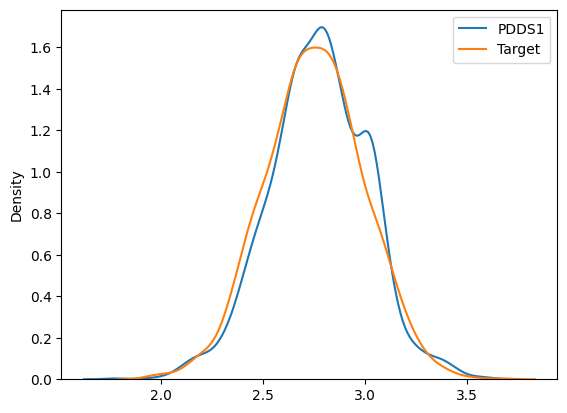

In [5]:
# initialise the new potential approximation using the learnt network
corrected_approx_potential = NNApproximatedPotential(
    base_potential=log_g0,
    dim=dim,
    nn_potential_approximator=partial(
        nn_potential_approximator.apply,
        params=training_state.params_ema
    )
)

# Instantiate SMCProblem class based on the learnt potential approximation
smc_problem = SMCProblem(sde, corrected_approx_potential, num_steps)

# Fast sampler
eval_sampler = jax.jit(
    partial(
        fast_outer_loop_smc,
        smc_problem=smc_problem,
        num_particles=(num_particles),
        ess_threshold=0.3,
        num_mcmc_steps=0,
        mcmc_step_size_scheduler=mcmc_step_size_scheduler,
        density_state=0,
    )
)

# Evaluate the normalising constant estimate averaging over 100 seeds
log_Z = np.zeros(100)
for i in tqdm.trange(100, disable=True):
    key, subkey = jax.random.split(key)
    smc_result, _ = eval_sampler(subkey)
    log_Z[i] = smc_result["log_normalising_constant"]

print('PDDS1 log Z estimate: ', np.mean(log_Z))

# Visualise samples
n_plot_samples = int(num_particles)
idx = jnp.arange(int(num_particles))
key, subkey1, subkey2, subkey3 = jax.random.split(key, 4)
target_samples = target_distribution.sample(subkey2, num_samples=n_plot_samples)
final_samples = resampler(
    rng=subkey3, samples=smc_result["samples"], log_weights=smc_result["log_weights"]
)["samples"]
    
# Visualise target, reference and samples
fig = plt.figure()
ax = fig.gca()
sns.kdeplot(final_samples[idx, 0], ax=ax, label="PDDS1")
sns.kdeplot(target_samples[:, 0], ax=ax, label="Target")
plt.legend()
plt.show()
plt.close(fig)